## CS 401 Applied Data Analysis, 2018 autumn
## Final Project: Exploration on Media polarity in the News
##### Group Members: Ruibin Huang, Liangwei Chen, Fengyu Cai

### Objective:
In this project, we would like to dig up the potential media polarity about the news on the websites. Through the year, we hope to find out the bias for some media as to some specific topics.

### Main Step
- Label the news with keywords or topic
    - TF-IDF
- Select specific news and medias for analysis in the similar time and topic
    - NLTK sentiment analysis package
- Further analyze based on the chronological and geometrical features of the medias
    - map or plot

Technologies applied (and will be applied): spark, Machine Learning, NLTK, Web Crawling

### About Datasets:
1. News Source: containing News IDs, Publisher, Publish Date, Publish Region, Publish Organization, News URL and News Title
2. News Excerpt: containing excerpts of website HTML, responding to the NEWs ID.
3. News parse and stemming: containing the canonical steming form of the news, which is convenient for manipulation and search.

### Milestone Summary:
In this milestone, we will do the analysis based on a limited data set: news on the website mainly during October in 2016 in the United States.
1. From News parse and stemming file, we applied TF-IDF to choose the linguitics keyword as document feature.
2. From the keywords set, we select some meaningful topic as our target.
3. For the document in selected documents, check whether there exist sentimental bias in this document, taking advantage of NLTK sentimental analysis.

In [414]:
# Import Module
import sys
import os
import re
import pandas as pd
import numpy as np
from collections import defaultdict
import string
import gc
import pickle
import matplotlib.pyplot as plt
from collections import Counter

# For the Topic-selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# For Website Crawling
from bs4 import BeautifulSoup
import requests

# For Sentimental Analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from textblob import TextBlob

### Part 1: Data Preprocessing

In [2]:
# data path
stm_file = '16-10-us.txt'
alter_file = '16-10-us-clean.txt'
src_file = 'now_sources_pt2.txt'
src_folder = 'source'

##### 1.1 Stemming File Clean:
As we find in the News Stemming File, there exits some illegal characters, therefore, we need to filter to get the pure data.

1.1.1 Encoding Issue

In [3]:
# remove the punctuations in the text
with open(stm_file, 'r', errors='replace', encoding='utf-8') as f:
    with open(alter_file ,'w') as w:
        w.write(re.sub('\t[' + string.punctuation + ']\t', '\tN/A\t', f.read()))

1.1.2 Select the write format data

In [4]:
id_c = re.compile(r'\d+')
def getId(line):
    return id_c.match(line).group(0)

In [115]:
colnames=['doc_id', 'word_id', 'word', 'origin_word', 'pos'] 
stemming_pd = pd.read_csv(alter_file, sep='\t', error_bad_lines=False, engine='python', header=None, names=colnames)

In [6]:
stemming_pd.head(10)

,doc_id,word_id,word,origin_word,pos
0,14637197,4739839025,@@14637197,NaN,fo
1,14637197,4739839026,<p>,NaN,null
2,14637197,4739839027,NEW,new,np1
3,14637197,4739839028,YORK,york,np1
4,14637197,4739839029,NaN,NaN,(
5,14637197,4739839030,AP,ap,np1
6,14637197,4739839031,NaN,NaN,)
7,14637197,4739839032,--,NaN,jj_nn1
8,14637197,4739839033,Donald,donald,np1
9,14637197,4739839034,Trump,trump,nn1


In [7]:
stemming_pd.dropna(inplace=True)

In [8]:
# after drop NA
stemming_pd.head(10)

,doc_id,word_id,word,origin_word,pos
2,14637197,4739839027,NEW,new,np1
3,14637197,4739839028,YORK,york,np1
5,14637197,4739839030,AP,ap,np1
8,14637197,4739839033,Donald,donald,np1
9,14637197,4739839034,Trump,trump,nn1
10,14637197,4739839035,'s,'s,ge
11,14637197,4739839036,five-day,five-day,jj
12,14637197,4739839037,feud,feud,nn1
13,14637197,4739839038,with,with,iw
14,14637197,4739839039,a,a,at1


In [9]:
stemming_list = stemming_pd.groupby('doc_id')['origin_word'].apply(list).apply(lambda x: ' '.join(x))

In [10]:
pd.DataFrame(stemming_list).head()

,origin_word
doc_id,
14637197,new york ap donald trump 's five-day feud with...
14637200,here be all the crazy stuff that happen at the...
14637201,another hotel want to build in the heart of ho...
14637202,in this sept 23 2016 photo rick retail sales m...
14637203,court erase jury award of punitive damage agai...


##### 1.2 Load the data Source

1.2.1 load new source data

In [11]:
new_src = pd.read_csv(os.path.join(src_folder, src_file), delimiter="\t", header=None, encoding = "ISO-8859-1")

In [12]:
new_src.columns=['id','unknown','date','country','media','website','title']

In [193]:
new_src.head(5)

,id,unknown,date,country,media,website,title,year,month,day
0,2930853,194,15-01-01,US,Consequence of Sound,http://consequenceofsound.net/2015/01/100000-c...,100000 copies of The Interview will be dropped...,15,01,01
1,2930854,266,15-01-01,US,Los Angeles Times,http://www.latimes.com/entertainment/movies/la...,'The Taking of Tiger Mountain' gets blockbuste...,15,01,01
2,2930855,701,15-01-01,US,TIME,http://time.com/3651697/afghanistan-war-cost/,The True Cost of the Afghanistan War May Surpr...,15,01,01
3,2930856,1963,15-01-01,US,The Week Magazine,http://theweek.com/articles/441310/confessions...,Confessions of a former TSA officer,15,01,01
4,2930859,263,15-01-01,US,Russia Beyond the Headlines,http://rbth.com/arts/2015/01/01/year_of_litera...,"Pushkin, Gogol and Akhmatova to be symbols of ...",15,01,01


1.2.2 Data filtering and selection

In [14]:
new_src['year'], new_src['month'], new_src['day'] = new_src['date'].str.split('-', 2).str

In [191]:
new_src.head(3)

,id,unknown,date,country,media,website,title,year,month,day
0,2930853,194,15-01-01,US,Consequence of Sound,http://consequenceofsound.net/2015/01/100000-c...,100000 copies of The Interview will be dropped...,15,01,01
1,2930854,266,15-01-01,US,Los Angeles Times,http://www.latimes.com/entertainment/movies/la...,'The Taking of Tiger Mountain' gets blockbuste...,15,01,01
2,2930855,701,15-01-01,US,TIME,http://time.com/3651697/afghanistan-war-cost/,The True Cost of the Afghanistan War May Surpr...,15,01,01


In [16]:
new_src_us = new_src[new_src['country']=='US']

In [18]:
data_US_16_10 = new_src_us[(new_src_us['year']=='16') & (new_src_us['month']=='10')]

In [27]:
data_US_16_10_sorted = data_US_16_10.sort_values(by='id')

In [192]:
data_US_16_10_sorted.head(3)

,id,unknown,date,country,media,website,title,year,month,day
304572,14637197,170,16-10-01,US,Bristol Herald Courier (press release) (blog),http://www.heraldcourier.com/news/trump-s-habi...,Trump's habit of fuming over slights comes at ...,16,10,01
304573,14637200,411,16-10-01,US,CBSSports.com,http://www.cbssports.com/college-football/news...,Here's all the crazy stuff that happened at th...,16,10,01
304574,14637201,159,16-10-01,US,Curbed LA,http://la.curbed.com/2016/9/30/13128220/hollyw...,11 story hotel proposed for the heart of Holly...,16,10,01


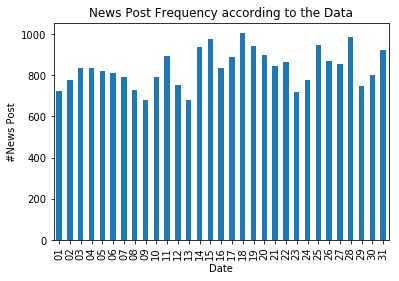

In [237]:
data_US_16_10_sorted['day'].value_counts().sort_index().plot.bar()
plt.title('News Post Frequency according to the Data')
plt.ylabel('#News Post')
plt.xlabel('Date')
plt.show()

##### 1.3 Load text of news

1.3.1 load the file

In [173]:
with open('16-10-us-txt.txt', 'r') as f:
    txt = f.read()

In [178]:
txt[:1500]

'@@14637197 <p> NEW YORK ( AP ) -- Donald Trump \'s five-day feud with a former beauty queen is only the latest example of his insistence on airing and re-airing his grievances no matter the political cost . <p> The Republican nominee \'s brash , confrontational style has thrilled his millions of supporters , who have cheered the celebrity businessman \'s tenacity and thirst for verbal combat . He bragged in the early weeks of his campaign last year , " When people treat me unfairly , I do n\'t let them forget it . " <h> Subscription Required <p> An online service is needed to view this article in its entirety . You need an online service to view this article in its entirety . <p> Thank you for reading 15 free articles on our site . You can come back at the end of your 30-day period for another 15 free articles , or you can purchase a subscription and continue to enjoy valuable local news and information . If you need help , please contact our office at 276-669-2181 . You need an onlin

1.3.2 Data formalization and cleaning

In [179]:
# re object defination
# get ID
id_tag = re.compile('\@\@([0-9]{8})')
# remove <p>, <p>
tagger = re.compile(r'\<.{1,2}\>')

In [242]:
iterpnt = id_tag.finditer(txt)
txt_dict = {}

In [243]:
# get id regexp object list
pnt_list = [pnt for pnt in iterpnt]

# get the 
for i in range(1, len(pnt_list)+1):
    if i < len(pnt_list):
        txt_dict[pnt_list[i-1].group(1)] = tagger.sub('', txt[pnt_list[i-1].span()[1]:pnt_list[i].span()[0]])
    else:
        txt_dict[pnt_list[i-1].group(1)] = tagger.sub('', txt[pnt_list[i-1].span()[1]:])

In [244]:
# get the 
txt_pd = pd.DataFrame(pd.Series(txt_dict, name='txt'))
txt_pd.head(5)

,txt
14637197,NEW YORK ( AP ) -- Donald Trump 's five-day ...
14637200,Here 's all the crazy stuff that happened at...
14637201,Another hotel wants to build in the heart of...
14637202,"In this Sept. 23 , 2016 photo , Rick Wollum ..."
14637203,Court erases jury award of punitive damages ...


In [245]:
txt_pd['txt'][0]

'  NEW YORK ( AP ) -- Donald Trump \'s five-day feud with a former beauty queen is only the latest example of his insistence on airing and re-airing his grievances no matter the political cost .  The Republican nominee \'s brash , confrontational style has thrilled his millions of supporters , who have cheered the celebrity businessman \'s tenacity and thirst for verbal combat . He bragged in the early weeks of his campaign last year , " When people treat me unfairly , I do n\'t let them forget it . "  Subscription Required  An online service is needed to view this article in its entirety . You need an online service to view this article in its entirety .  Thank you for reading 15 free articles on our site . You can come back at the end of your 30-day period for another 15 free articles , or you can purchase a subscription and continue to enjoy valuable local news and information . If you need help , please contact our office at 276-669-2181 . You need an online service to @ @ @ @ @ @ 

### Part 2: Topic Selection

After data processing, we step to the next step of topic selection. We will use the methods of TF-IDF, which has been embeded in skicit-learn.

In [30]:
# In the milestone, we only consider 1-gram in the tf-idf
countvec = CountVectorizer(stop_words='english', ngram_range=(1,1))
tfidfvec = TfidfTransformer()

In [31]:
text_list = list(stemming_list.values)
ind_list = list(stemming_list.keys())

In [32]:
word_freq = countvec.fit_transform(text_list)

In [34]:
# get the number of news and the number of 1-gram
num_doc, num_feat = word_freq.shape

In [50]:
# 1-gram words sorted in alphabetal order
features = countvec.get_feature_names()
features[10000:10010]

['burke',
 'burkett',
 'burkhardt',
 'burkholder',
 'burkina',
 'burkitt',
 'burkle',
 'burks',
 'burlap',
 'burleigh']

In [39]:
word_freq

<23055x65844 sparse matrix of type '<class 'numpy.int64'>'
	with 2365276 stored elements in Compressed Sparse Row format>

We find that the word freqency matrix is highly sparse.

In [45]:
# glance at the sparse matrix
pd.DataFrame(word_freq[0:10].toarray(), columns=countvec.get_feature_names())

,00,000,0000,000th,001,002,0023,003,004,005,...,zuzu,zverev,zvi,zweig,zwick,zwierlein,zwilling,zx,zygote,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# from sparse word frequency, calculate the tf-idf matrix
tfidf = tfidfvec.fit_transform(word_freq)

In [54]:
# get the entries with value in the sparse matrix
entries = tfidf.tolil().rows

In [70]:
# the keywords of the first docoment
pd.DataFrame(features).iloc[entries[0]].head(10)

,0
359,15
1109,30
3354,airing
4627,ap
5203,article
7081,beauty
9095,brag
9179,brash
10092,businessman
10499,campaign


In [158]:
# record the keyword index for each document
tfidf_matrix = [[(entries[doc][i], tfidf[doc].toarray()[0][entries[doc][i]]) for i in range(len(entries[doc]))] for doc in range(num_doc)]

In [162]:
# save the matrix to pickle
with open('tfidf.pickle', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

In [75]:
# load the pickle to tfidf-matrix
with open('tfidf.pickle', 'rb') as w:
    tfidf_matrix = pickle.load(w)

In [82]:
tfidf_top10 = [sorted(tfidf_matrix[i], key=lambda x: x[1], reverse=True)[:10] for i in range(num_doc)]

In [83]:
tfidf_top10_name = [[(features[x[0]], x[1]) for x in tfidf_top10[i]] for i in range(num_doc)]

In [92]:
# convert to pandas DataFrame
tfidf_top10_pd = pd.DataFrame(tfidf_top10_name, index=ind_list)
tfidf_top10_pd.index.name = 'Id'

In [93]:
tfidf_top10_pd.head()

,0,1,2,3,4,5,6,7,8,9
Id,,,,,,,,,,
14637197,"(article, 0.3231129513690259)","(entirety, 0.2510290164608949)","(online, 0.24465264706847722)","(need, 0.2234580095033969)","(subscription, 0.2170400061690015)","(service, 0.19894874553392955)","(confrontational, 0.1791444819081644)","(tenacity, 0.17376868493437247)","(brash, 0.16827200370669051)","(thirst, 0.167100838004032)"
14637200,"(toledo, 0.5006275298991661)","(byu, 0.2251267442257118)","(mack, 0.20236457207395567)","(woodside, 0.1817846776596635)","(game, 0.1708867364649886)","(broadcast, 0.13848178834439617)","(brown, 0.1312003993314338)","(grab, 0.13073268144047578)","(replay, 0.13036903363929486)","(ensuing, 0.12703707069285639)"
14637201,"(cahuenga, 0.3443785000085918)","(hollywood, 0.3316018473377978)","(hotel, 0.24975932711993432)","(project, 0.19498070640999493)","(parking, 0.18095834624622986)","(developer, 0.18047271513603777)","(plan, 0.16774698785252296)","(construction, 0.16458284194527986)","(334, 0.16066043091749754)","(palladium, 0.15135258208225924)"
14637202,"(river, 0.43741932617450596)","(whitefish, 0.41041669203250136)","(yellowstone, 0.35392258902672885)","(fish, 0.28701407869412077)","(biologist, 0.19724807594786847)","(angler, 0.16060113092124212)","(parasite, 0.15484113269919386)","(fishing, 0.14065077888172087)","(trout, 0.12981872039072806)","(rachel, 0.11717566543629883)"
14637203,"(punitive, 0.3455224429347211)","(newsgathering, 0.2737209523650647)","(motorcyclist, 0.2466180682188501)","(claim, 0.22002071797655545)","(erase, 0.2046431001293423)","(insurer, 0.20416982741935266)","(standard, 0.20136157039367233)","(damage, 0.1928329657221136)","(ruling, 0.1713627098884841)","(court, 0.1687594859435715)"


In [94]:
tfidf_top10_Nameset = [x[0] for i in range(num_doc) for x in tfidf_top10_name[i]]

In [96]:
tfidf_top5_key = [[x[0] for x in tfidf_top10_name[i]] for i in range(num_doc)]

In [97]:
cnt = Counter(tfidf_top10_Nameset)

In [105]:
key_words_pd = pd.DataFrame(pd.Series(dict(cnt)), columns=['Frequency'])

In [107]:
key_words_top20 = key_words_pd.sort_values(by='Frequency', ascending=False).iloc[:20]
key_words_top20.index.name = 'Keywords'

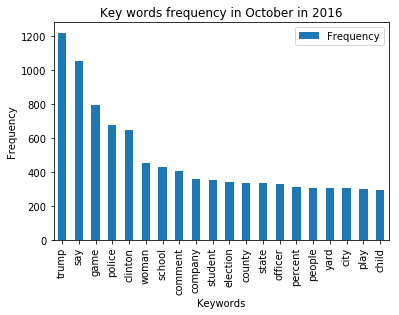

In [247]:
key_words_top20.plot(kind='bar')
plt.title('Key words frequency in October in 2016')
plt.ylabel('Frequency')
plt.xlabel('Keywords')
plt.show()

In [248]:
key_words_top20.head()

,Frequency
Keywords,
trump,1219
say,1049
game,792
police,676
clinton,648


### Discovery:
After our tfidf analysis, we could find out that in the month rightly before American Precidental Election held on 8th November 2016, many pieces of news are highly related to the presidential election.

In [211]:
trump_list = [ind_list[i] for i in range(num_doc) if 'trump' in tfidf_top5_key[i]]

In [216]:
with open('trump_list.pickle', 'wb') as w:
    pickle.dump(trump_list, w)

### Part3: Get Original Data from Website

In [272]:
tags_re = re.compile(r'(\<.*\>|\s+)')

In [416]:
def HTMLGetandParser(url):
    """
        Aimed to get the information based URL, and parse and select the data according to HTML
        input: url
        output: txt
    """
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    paragraph = soup.p
    txt = ''
    
    while paragraph:
        txt += (tags_re.sub(' ', str(paragraph)) if len(str(paragraph)) > 1000 else '')
        paragraph = paragraph.next
    return txt

In [417]:
web_pd = data_US_16_10_sorted.iloc[:100]['website'].apply(lambda url: HTMLGetandParser(url))

### Part4: Sentimental Analysis

In [366]:
def sentiment_TextBlob(text,pos_threshold = 0.3,neg_threshold = -0.3):
    """
    Get polarity of text by mean of polarity of each sentence
    Since most sentences convey nothing in an article, we decide to eliminate neutral sentence
    and only take polar sentence into account
    If there is no polar sentence in an article, return 0
    Params: text: str
            pos_threshold: float
            neg_threshold: float
    """
    # Get blob
    blob = TextBlob(text)
    
    # Get sentence objs
    sentences = blob.sentences
    
    # Get sentence polarity
    polarity = list(map(lambda x: 1 if x.sentiment[0] > pos_threshold \
                                    else (-1 if x.sentiment[0] < neg_threshold \
                                             else 0),
                      sentences))
    
    # Calculate article polarity
    polarity = np.array(polarity)
    if np.all(np.unique(polarity) == 0):
        return 0
    
    return np.sum(polarity) / np.sum(polarity != 0)

In [367]:
def sentiment_nltk(text,pos_threshold = 0.3,neg_threshold = -0.3):
    '''
    Get polarity of article using nltk
    Params: text: str
            pos_threshold: float
            neg_threshold: float
    Return: polarity
    '''
    
    # Get sentences
    sentences=nltk.sent_tokenize(text)
    
    # Get polarity analyzer
    sid = SentimentIntensityAnalyzer()

    # Calculate scores and polarity of sentences
    scores = list(map(lambda x: sid.polarity_scores(x)['compound'], sentences))
    polarity = list(map(lambda x: 1 if x > pos_threshold \
                                       else (-1 if x < neg_threshold \
                                            else 0),
                       scores))

    # Calculate article polarity
    polarity = np.array(polarity)
    if np.all(np.unique(polarity) == [0]):
        return 0
    
    return np.sum(polarity) / np.sum(polarity != 0)

In [368]:
def find_polarity_tags(articles):
    '''
    Return polarity for articles using mean of nltk and textblob
    Params: articles: Array(str)
    Return: tags
    '''
    
    polarity_articles = list(map(lambda x: np.mean([sentiment_TextBlob(x),
                                                   sentiment_nltk(x)]),
                               articles))
    
    return polarity_articles

    polarity_tags=[]
    for i in range(len(articles)):
        tag_blob=sentiment_TextBlob(articles[i],0,0)
        tag_nltk=sentiment_nltk(articles[i],0,0)
        polarity_tag=determine_tag(tag_blob+tag_nltk)
        polarity_tags.append(polarity_tag)
    return polarity_tags

In [280]:
Trump_list=pd.read_pickle('trump_list.pickle')

In [284]:
mask = data_US_16_10['id'].isin(Trump_list)
data_Trump=data_US_16_10_sorted.loc[mask]

In [288]:
txt_pd.reset_index(inplace=True)

In [306]:
txt_pd['index_int'] = txt_pd['index'].apply(lambda x: int(x))

In [307]:
Trump_news_16_10 = data_Trump.merge(txt_pd, how='inner', left_on='id', right_on='index_int')

In [308]:
Trump_news_16_10

,id,unknown,date,country,media,website,title,year,month,day,index,txt,index_str,index_int
0,14642538,887,16-10-01,US,The State,http://www.thestate.com/news/politics-governme...,Horry County voters reflect frustration of Tru...,16,10,01,14642538,Lucy Cesar-Jedacek walked into the Horry Cou...,14642538,14642538
1,14645950,266,16-10-01,US,Entertainment Weekly,http://www.ew.com/article/2016/10/01/art-deal-...,The Art of the Deal ghostwriter claims Donald ...,16,10,01,14645950,"See also Tony Schwartz , the ghostwriter wh...",14645950,14645950
2,14645980,833,16-10-01,US,The Seattle Times,http://www.seattletimes.com/opinion/the-death-...,The death of idealism,16,10,01,14645980,The death of idealism Share story This pre...,14645980,14645980
3,14645984,4345,16-10-01,US,Outside the Beltway,http://www.outsidethebeltway.com/on-the-potent...,On the Potential Global Consequences of a Trum...,16,10,01,14645984,On the Potential Global Consequences of a Tr...,14645984,14645984
4,14647956,4657,16-10-01,US,Chicago Tribune,http://www.chicagotribune.com/news/nationworld...,The journey of a Trump true believer: 'Finally...,16,10,01,14647956,The journey of a Trump true believer : ' Fin...,14647956,14647956
5,14648467,206,16-10-01,US,Bloomberg,http://www.bloomberg.com/politics/trackers/201...,MORE: NYT Says It Has Obtained Some of Trump's...,16,10,01,14648467,Records suggest Republican presidential cand...,14648467,14648467
6,14648476,811,16-10-01,US,Washington Examiner (blog),http://www.washingtonexaminer.com/ny-times-rec...,NY Times received copy of Trump's 1995 tax ret...,16,10,01,14648476,"MANHEIM , Pa. -- Donald Trump declared a $91...",14648476,14648476
7,14648493,506,16-10-01,US,Mother Jones,http://www.motherjones.com/politics/2016/10/do...,Bombshell New York Times Report Reveals Detail...,16,10,01,14648493,Tax experts hired by the Times said that the...,14648493,14648493
8,14648502,291,16-10-01,US,newsnet5.com,http://www.newsnet5.com/news/local-news/oh-cuy...,NAACP rebukes Cleveland police union's endorse...,16,10,01,14648502,The NAACP declared four major reasons why th...,14648502,14648502
9,14648518,415,16-10-01,US,Business Insider,http://www.businessinsider.com/donald-trump-ta...,The New York Times just published some of Dona...,16,10,01,14648518,The New York Times just published some of Do...,14648518,14648518


In [369]:
Trump_news_16_10['tag'] = Trump_news_16_10['txt'].apply(lambda x: find_polarity_tags([x])[0])

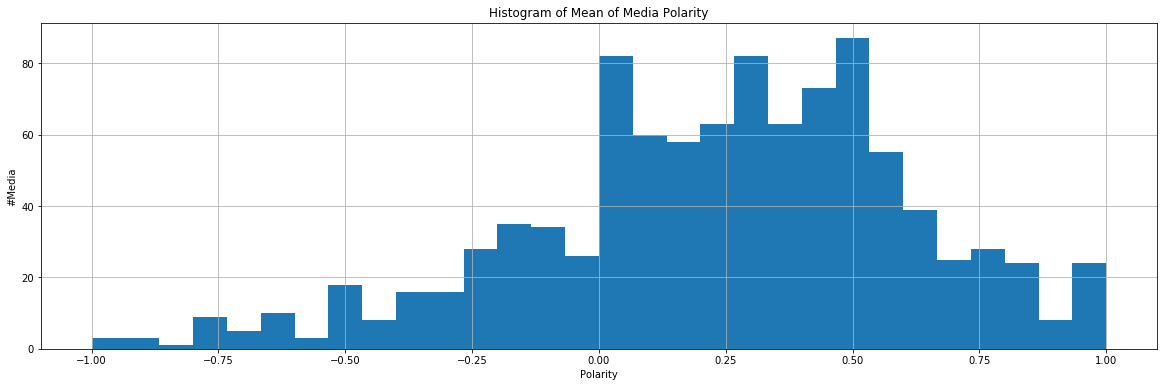

In [413]:
Trump_news_16_10['tag'].hist(bins=30, grid=True)
plt.title('Histogram of Mean of Media Polarity')
plt.xlabel('Polarity')
plt.ylabel('#Media')
plt.show()

In [371]:
Trump_media = Trump_news_16_10.groupby('media')['tag'].apply(list)

In [372]:
Trump_media_top12 = Trump_media.iloc[[i for i in range(Trump_media.size) if len(Trump_media[i]) > 12]]

In [373]:
tmp = Trump_media_top12.to_frame()

In [387]:
tmp['count'] = tmp['tag'].apply(len)

In [385]:
tmp['mean'] = tmp['tag'].apply(np.mean)

In [389]:
mean_polarity = np.sum(tmp['count'] * tmp['mean']) / np.sum(tmp['count'])

In [390]:
mean_polarity

0.2644985511630081

In [394]:
Trump_media_top12

media
ABC News             [0.45454545454545453, 0.5555555555555556, 0.75...
CBS News             [-0.6666666666666666, 0.5, 0.25, 0.05128205128...
CNN                  [0.9, -0.16666666666666666, 0.2805031446540880...
FiveThirtyEight      [0.4725274725274725, 0.4560478199718706, 0.833...
Huffington Post      [0.0, 0.3277310924369748, 0.29166666666666663,...
Los Angeles Times    [0.41666666666666663, 0.5, -0.1666666666666666...
Mother Jones         [0.7777777777777778, 0.7727272727272727, -0.05...
NBCNews.com          [0.3055555555555556, 0.27058823529411763, 0.13...
Politico             [0.4, 0.33333333333333337, 0.2879310344827586,...
PoliticusUSA         [-0.26666666666666666, -0.1, 0.504273504273504...
Raw Story            [0.15833333333333333, 0.41666666666666663, -0....
Salon                [0.2556818181818182, 0.15873015873015872, -0.1...
TPM                  [-0.7142857142857143, -0.30952380952380953, 0....
The Atlantic         [0.4264007597340931, 0.06987788331071913, 0.26...


In [396]:
Trump_media_top = Trump_media_top12.apply(lambda x: [i - mean_polarity for i in x])

In [397]:
data = Trump_media_top.values

In [398]:
index = tmp.index

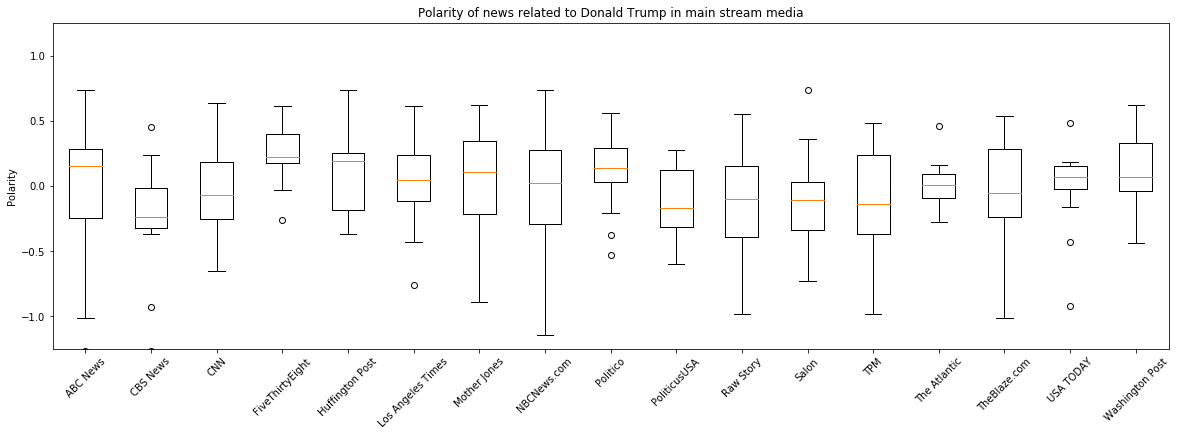

In [407]:
plt.rcParams['figure.figsize'] = (20, 6)
plt.boxplot(list(data))
plt.xticks(np.arange(len(index)) + 1, index, rotation=45)
plt.ylim(-1.25, 1.25)
plt.ylabel('Polarity')
plt.title('Polarity of news related to Donald Trump in main stream media')
plt.show()